In [1]:
# Grid isochrones for Greenland radiostratigraphy v2 following GStatSim template.
# 
# Joe MacGregor (NASA/GSFC)
# Last updated: 16 August 2024

# package import
import geopandas as gpd
import glob
import gstatsim as gs
import hdf5storage
import matplotlib.path as mplpath
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import skgstat as skg
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon, LineString, Point, MultiPoint
from sklearn.preprocessing import QuantileTransformer 
from skgstat import models

path_csv = '/Users/jamacgre/OneDrive - NASA/research/matlab/pickgui_v2/csv/'
path_mat = '/Users/jamacgre/OneDrive - NASA/research/matlab/pickgui_v2/mat/'
grd_res = 5e3 # grid resolution for kriging, m
x_min, x_max, y_min, y_max = -630e3, 845e3, -3340e3, -670e3 # Greenland extent, EPSG:3413 m

In [2]:
# read in CSV files with isochrone depths

# start with isochrone depths
dir_iso_csv = sorted(glob.glob(path_csv + 'depth_iso1_*.csv'))
num_age_iso = len(dir_iso_csv)

depth_iso_df, depth_iso_df_init = [None] * num_age_iso, [None] * num_age_iso
age_iso = np.empty((num_age_iso), dtype=np.float64)

# loop through each depth_iso1 CSV file and load it
for i, csv_curr in enumerate(dir_iso_csv):
    print(str(i) + ': ' + csv_curr[len(path_csv):].split('_')[2] + ' ka')
    age_iso[i] = np.float64(csv_curr[len(path_csv):].split('_')[2])
    depth_iso_df_init[i] = pd.read_csv(csv_curr)
    depth_iso_df_init[i]['depth_norm1'] = np.divide(depth_iso_df_init[i]['depth'], depth_iso_df_init[i]['thickness']) # thickness-normalized depth
    # ind_bad = np.union1d(np.union1d(np.union1d(np.argwhere(np.isinf(depth_iso_df_init[i]['depth_norm1'])), np.argwhere(depth_iso_df_init[i]['depth_norm1'] <= 0.01)), np.argwhere(depth_iso_df_init[i]['depth_norm1'] >= 0.9)), np.argwhere(np.isnan(depth_iso_df_init[i]['uncertainty'])))
    # depth_iso_df_init[i].loc[ind_bad, 'depth_norm1'] = np.nan # due to zero/unknown thickness or missing age uncertainty
    depth_iso_df_init[i] = depth_iso_df_init[i].drop(np.flatnonzero(np.isnan(depth_iso_df_init[i]['uncertainty']))) # remove rows with NaN uncertainty

# sort by age
idx_age_sort = np.argsort(age_iso)
age_iso = age_iso[idx_age_sort]
for i in range(num_age_iso):
    depth_iso_df[i] = depth_iso_df_init[idx_age_sort[i]]

del depth_iso_df_init

0: 11.7 ka
1: 115 ka
2: 12.8 ka
3: 14.7 ka
4: 19 ka
5: 29 ka
6: 3 ka
7: 57 ka
8: 8 ka
9: 9 ka


In [3]:
# next do depth-normalized ages
dir_norm_csv = sorted(glob.glob(path_csv + 'age_norm1_*.csv'))
num_depth_norm = len(dir_norm_csv)

age_norm_df = [None] * num_depth_norm
depth_norm = np.empty((num_depth_norm), dtype=np.float64)

# loop through each age_norm1 CSV file and load it
for i, csv_curr in enumerate(dir_norm_csv):
    print(str(i) + ': ' + csv_curr[len(path_csv):].split('_')[2][0:3] + '%')
    depth_norm[i] = np.float64(csv_curr[len(path_csv):].split('_')[2][0:3])
    age_norm_df[i] = pd.read_csv(csv_curr)
    age_norm_df[i] = age_norm_df[i].drop(np.flatnonzero(np.isnan(age_norm_df[i]['uncertainty']))) # remove rows with NaN uncertainty

0: 005%
1: 010%
2: 015%
3: 020%
4: 025%
5: 030%
6: 035%
7: 040%
8: 045%
9: 050%
10: 055%
11: 060%
12: 065%
13: 070%
14: 075%
15: 080%
16: 085%
17: 090%
18: 095%
19: 100%


In [ ]:
# plot depth of each isochrone

fig, ax = plt.subplots(4, 3, figsize=(12, 12), layout='constrained')
for i in range(num_age_iso):
    plt.subplot(4, 3, (i + 1))
    im = plt.scatter((1e-3 * depth_iso_df[i]['x']), (1e-3 * depth_iso_df[i]['y']), c=depth_iso_df[i]['depth'], vmin=np.min(depth_iso_df[i]['depth']), vmax=np.max(depth_iso_df[i]['depth']), marker='.', s=0.5, cmap='gist_earth')
    plt.title('Depth of ' + str(age_iso[i]) + ' ka isochrone (m)')
    plt.xlabel('EPSG:3413 X (km)')
    plt.ylabel('EPSG:3413 Y (km)')
    plt.axis(1e-3 * np.array([x_min, x_max, y_min, y_max]))
    plt.gca().set_aspect('equal')
    plt.colorbar(im, ticks=np.linspace(np.min(depth_iso_df[i]['depth']), np.max(depth_iso_df[i]['depth']), 11))

In [ ]:
# plot age of each normalized depth

fig, ax = plt.subplots(4, 5, figsize=(12, 12), layout='constrained')
for i in range(num_depth_norm):
    plt.subplot(4, 5, (i + 1))
    im = plt.scatter((1e-3 * age_norm_df[i]['x']), (1e-3 * age_norm_df[i]['y']), c=(1e-3 * age_norm_df[i]['age']), vmin=(1e-3 * np.min(age_norm_df[i]['age'])), vmax=(1e-3 * np.max(age_norm_df[i]['age'])), marker='.', s=0.5, cmap='gist_earth')
    plt.title('Age at ' + str(depth_norm[i]) + '% depth (ka)')
    plt.xlabel('EPSG:3413 X (km)')
    plt.ylabel('EPSG:3413 Y (km)')
    plt.axis(1e-3 * np.array([x_min, x_max, y_min, y_max]))
    plt.gca().set_aspect('equal')
    plt.colorbar(im, ticks=np.linspace((1e-3 * np.min(age_norm_df[i]['age'])), (1e-3 * np.max(age_norm_df[i]['age'])), 11))

In [4]:
# resample data to a regular grid interval
# depth_iso_grd, depth_iso_grd_mat = [None] * num_age_iso, [None] * num_age_iso
# num_row_grd, num_col_grd = np.empty((num_age_iso), dtype=np.int64), np.empty((num_age_iso), dtype=np.int64)

# normal score transformer for isochrone depth
nst_trans_iso, nst_trans_iso_uncert = [None] * num_age_iso, [None] * num_age_iso

# loop through each isochrone, resample and normalize
for i in range(num_age_iso):
    nst_trans_iso[i] = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(depth_iso_df[i]['depth'].values.reshape(-1, 1))
    depth_iso_df[i]['depth_norm2'] = nst_trans_iso[i].transform(depth_iso_df[i]['depth'].values.reshape(-1, 1))
    nst_trans_iso_uncert[i] = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(depth_iso_df[i]['uncertainty'].values.reshape(-1, 1))
    depth_iso_df[i]['uncertainty_norm'] = nst_trans_iso_uncert[i].transform(depth_iso_df[i]['uncertainty'].values.reshape(-1, 1))
    # depth_iso_grd[i], depth_iso_grd_mat[i], num_row_grd[i], num_col_grd[i] = gs.Gridding.grid_data(depth_iso_df[i], 'x', 'y', 'depth', grd_res)
    # depth_iso_grd[i] = depth_iso_grd[i][depth_iso_grd[i]['Z'].isnull() == False]
    # # normal score transformation
    # depth_iso_grd[i]['depth_norm2'] = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(depth_iso_grd[i]['Z'].values.reshape(-1, 1)).transform(depth_iso_grd[i]['Z'].values.reshape(-1, 1))

# normal score transformer now for depth-normalized age
nst_trans_norm, nst_trans_norm_uncert = [None] * (num_depth_norm - 4), [None] * (num_depth_norm - 4)

# loop through each normalized depth, resample and normalize
for i in range(num_depth_norm - 4):
    nst_trans_norm[i] = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(age_norm_df[i]['age'].values.reshape(-1, 1))    
    age_norm_df[i]['age_norm'] = nst_trans_norm[i].transform(age_norm_df[i]['age'].values.reshape(-1, 1))
    nst_trans_norm_uncert[i] = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(age_norm_df[i]['uncertainty'].values.reshape(-1, 1))
    age_norm_df[i]['uncertainty_norm'] = nst_trans_norm_uncert[i].transform(age_norm_df[i]['uncertainty'].values.reshape(-1, 1))

In [ ]:
# # plot resampled depths NO LONGER NECESSARY
# fig, ax = plt.subplots(4, 3, figsize=(12, 12), layout='constrained')
# for i in range(num_age_iso):
#     plt.subplot(4, 3, (i + 1))
#     im = plt.imshow(depth_iso_grd_mat[i], extent=(1e-3 * np.array([np.min(depth_iso_grd[i]['X']), np.max(depth_iso_grd[i]['X']), np.min(depth_iso_grd[i]['Y']), np.max(depth_iso_grd[i]['Y'])])), 
#                    cmap='gist_earth', vmin=np.nanmin(depth_iso_grd_mat[i]), vmax=np.nanmax(depth_iso_grd_mat[i]), interpolation='none', origin='upper')
#     plt.title('Re-gridded depth of ' + str(age_iso[i]) + ' ka isochrone')
#     plt.xlabel('EPSG:3413 X (km)')
#     plt.ylabel('EPSG:3413 Y (km)')
#     plt.axis(1e-3 * np.array([x_min, x_max, y_min, y_max]))
#     plt.gca().set_aspect('equal')
#     plt.colorbar(im, ticks=np.linspace(np.nanmin(depth_iso_grd_mat[i]), np.nanmax(depth_iso_grd_mat[i]), 11))

In [ ]:
# plot one of the normalized histograms for isochrone depth

idx2plt = 2

# plot original depth histogram then normal score histogram (with weights)
plt.subplot(121)
# plt.hist(depth_iso_grd[idx2plt]['Z'], facecolor='red', bins=50, alpha=0.5, edgecolor='k')
# plt.xlim([np.nanmin(depth_iso_grd[idx2plt]['Z']), np.nanmax(depth_iso_grd[idx2plt]['Z'])]); 
plt.hist(depth_iso_df[idx2plt]['depth'], facecolor='red', bins=50, alpha=0.5, edgecolor='k')
plt.xlim([np.nanmin(depth_iso_df[idx2plt]['depth']), np.nanmax(depth_iso_df[idx2plt]['depth'])]); 
plt.xlabel('Depth (m)'); plt.ylabel('Frequency'); plt.title('Raw depth for ' + str(age_iso[idx2plt]) + ' ka isochrone')
plt.grid(True)
plt.subplot(122)
# plt.hist(depth_iso_grd[idx2plt]['depth_norm2'], facecolor='red', bins=50, alpha=0.5, edgecolor='k')
# plt.xlim([np.nanmin(depth_iso_grd[idx2plt]['depth_norm2']), np.nanmax(depth_iso_grd[idx2plt]['depth_norm2'])]); 
plt.hist(depth_iso_df[idx2plt]['depth_norm2'], facecolor='red', bins=50, alpha=0.5, edgecolor='k')
plt.xlim([np.nanmin(depth_iso_df[idx2plt]['depth_norm2']), np.nanmax(depth_iso_df[idx2plt]['depth_norm2'])]); 
plt.xlabel('Normalized depth'); plt.ylabel('Frequency'); plt.title('Normalized depth')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

In [ ]:
# plot original depth uncertainty histogram then normal score histogram (with weights)
idx2plt = 2
plt.subplot(121)
plt.hist(depth_iso_df[idx2plt]['uncertainty'], facecolor='red', bins=50, alpha=0.5, edgecolor='k')
plt.xlim([np.nanmin(depth_iso_df[idx2plt]['uncertainty']), np.nanmax(depth_iso_df[idx2plt]['uncertainty'])]); 
plt.xlabel('Depth (m)'); plt.ylabel('Frequency'); plt.title('Raw depth uncertainty for ' + str(age_iso[idx2plt]) + ' ka isochrone')
plt.grid(True)
plt.subplot(122)
plt.hist(depth_iso_df[idx2plt]['uncertainty_norm'], facecolor='red', bins=50, alpha=0.5, edgecolor='k')
plt.xlim([np.nanmin(depth_iso_df[idx2plt]['uncertainty_norm']), np.nanmax(depth_iso_df[idx2plt]['uncertainty_norm'])]); 
plt.xlabel('Normalized depth'); plt.ylabel('Frequency'); plt.title('Normalized depth uncertainty')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

In [ ]:
# plot one of the normalized histograms for depth-normalized age

idx2plt = 10

# plot original age histogram then normal score histogram (with weights)
plt.subplot(121)
plt.hist((1e-3 * age_norm_df[idx2plt]['age']), facecolor='red', bins=50, alpha=0.5, edgecolor='k')
plt.xlim([(1e-3 * np.nanmin(age_norm_df[idx2plt]['age'])), (1e-3 * np.nanmax(age_norm_df[idx2plt]['age']))]); 
plt.xlabel('Age (ka)'); plt.ylabel('Frequency'); plt.title('Raw age for ' + str(depth_norm[idx2plt]) + '% depth')
plt.grid(True)
plt.subplot(122)
plt.hist(age_norm_df[idx2plt]['age_norm'], facecolor='red', bins=50, alpha=0.5, edgecolor='k')
plt.xlim([np.nanmin(age_norm_df[idx2plt]['age_norm']), np.nanmax(age_norm_df[idx2plt]['age_norm'])]); 
plt.xlabel('Normalized age'); plt.ylabel('Frequency'); plt.title('Normalized age')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

In [ ]:
# plot one of the normalized histograms for depth-normalized age uncertainty
idx2plt = 14
plt.subplot(121)
plt.hist((1e-3 * age_norm_df[idx2plt]['uncertainty']), facecolor='red', bins=50, alpha=0.5, edgecolor='k')
plt.xlim([(1e-3 * np.nanmin(age_norm_df[idx2plt]['uncertainty'])), (1e-3 * np.nanmax(age_norm_df[idx2plt]['uncertainty']))]); 
plt.xlabel('Age uncertainty (ka)'); plt.ylabel('Frequency'); plt.title('Raw age uncertainty for ' + str(depth_norm[idx2plt]) + '% depth')
plt.grid(True)
plt.subplot(122)
plt.hist(age_norm_df[idx2plt]['uncertainty_norm'], facecolor='red', bins=50, alpha=0.5, edgecolor='k')
plt.xlim([np.nanmin(age_norm_df[idx2plt]['uncertainty_norm']), np.nanmax(age_norm_df[idx2plt]['uncertainty_norm'])]); 
plt.xlabel('Normalized age uncertainty'); plt.ylabel('Frequency'); plt.title('Normalized age uncertainty')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

In [ ]:
# VARIOGRAMS for isochrone depth

# binning parameters
max_lag = 50e3 # maximum range distance, m (same as v1)
num_lags = 70 # num of bins

variogram_depth_iso, variogram_depth_iso_uncert = [None] * num_age_iso, [None] * num_age_iso

# experimental semi-variogram
for i in range(num_age_iso):
    print(i)
    # variogram_depth_iso[i] = skg.Variogram(depth_iso_grd[i][['X', 'Y']].values, depth_iso_grd[i]['depth_norm2'], bin_func='even', n_lags=num_lags, maxlag=max_lag, normalize=False)    
    variogram_depth_iso[i] = skg.Variogram(depth_iso_df[i][['x', 'y']].values, depth_iso_df[i]['depth_norm2'], bin_func='even', n_lags=num_lags, maxlag=max_lag, normalize=False)
    variogram_depth_iso_uncert[i] = skg.Variogram(depth_iso_df[i][['x', 'y']].values, depth_iso_df[i]['uncertainty_norm'], bin_func='even', n_lags=num_lags, maxlag=max_lag, normalize=False)

# copy experimental variogram in preparation for model calculation 
variogram_exp_iso, variogram_sph_iso, variogram_gauss_iso, variogram_exp_iso_uncert, variogram_sph_iso_uncert, variogram_gauss_iso_uncert = variogram_depth_iso, variogram_depth_iso, variogram_depth_iso, variogram_depth_iso_uncert, variogram_depth_iso_uncert, variogram_depth_iso_uncert

# calculate each model variogram parameters for each isochrone
for i in range(num_age_iso):
    variogram_exp_iso[i].model = 'exponential' # better for deepest layers
    # variogram_gauss_iso[i].model = 'gaussian'
    variogram_sph_iso[i].model = 'spherical' #winning
    variogram_exp_iso_uncert[i].model = 'exponential' # better for deepest layers
    variogram_gauss_iso[i].model = 'gaussian'
    variogram_sph_iso_uncert[i].model = 'spherical' #winning

model_selection_iso = ('spherical', 'spherical', 'spherical', 'spherical', 'spherical', 'spherical', 'spherical', 'exponential', 'exponential', 'exponential')

In [5]:
# VARIOGRAMS for depth-normalized age

# binning parameters
max_lag = 50e3 # maximum range distance, m (same as v1)
num_lags = 70 # num of bins

variogram_age_norm, variogram_age_norm_uncert = [None] * (num_depth_norm - 4), [None] * (num_depth_norm - 4)

# experimental semi-variogram
for i in range(num_depth_norm - 4):
    print(i)
    variogram_age_norm[i] = skg.Variogram(age_norm_df[i][['x', 'y']].values, age_norm_df[i]['age_norm'], bin_func='even', n_lags=num_lags, maxlag=max_lag, normalize=False)
    variogram_age_norm_uncert[i] = skg.Variogram(age_norm_df[i][['x', 'y']].values, age_norm_df[i]['uncertainty_norm'], bin_func='even', n_lags=num_lags, maxlag=max_lag, normalize=False)

# copy experimental variogram in preparation for model calculation 
variogram_exp_norm, variogram_sph_norm, variogram_gauss_norm, variogram_exp_norm_uncert, variogram_sph_norm_uncert, variogram_gauss_norm_uncert = variogram_age_norm, variogram_age_norm, variogram_age_norm, variogram_age_norm_uncert, variogram_age_norm_uncert, variogram_age_norm_uncert

# calculate each model variogram parameters for each isochrone
for i in range(num_depth_norm - 4):
    # variogram_exp_norm[i].model = 'exponential'
    # variogram_gauss_norm[i].model = 'gaussian'
    variogram_sph_norm[i].model = 'spherical' #winning
    # variogram_exp_norm_uncert[i].model = 'exponential'
    # variogram_gauss_norm_uncert[i].model = 'gaussian'
    variogram_sph_norm_uncert[i].model = 'spherical' #winning

model_selection_norm = 'spherical'

14
15


In [ ]:
# plot experimental and model semi-variograms for isochrone depths

fig, ax = plt.subplots(4, 3, figsize=(12, 10), layout='constrained')
for i in range(num_age_iso):
    print(i)
    plt.subplot(4, 3, (i + 1))
    plt.scatter((1e-3 * variogram_depth_iso[i].bins), variogram_depth_iso[i].experimental, s=12, c='k', label='experimental')
    plt.plot((1e-3 * variogram_depth_iso[i].bins), models.exponential(np.linspace(0, variogram_depth_iso[i].bins[-1], num_lags), variogram_exp_iso[i].parameters[0], variogram_exp_iso[i].parameters[1], variogram_exp_iso[i].parameters[2]), 'r-', label='exponential')
    # plt.plot((1e-3 * variogram_depth_iso[i].bins), models.gaussian(np.linspace(0, variogram_depth_iso[i].bins[-1], num_lags), variogram_gauss_iso[i].parameters[0], variogram_gauss_iso[i].parameters[1], variogram_gauss_iso[i].parameters[2]), 'g-', label='gaussian')
    plt.plot((1e-3 * variogram_depth_iso[i].bins), models.spherical(np.linspace(0, variogram_depth_iso[i].bins[-1], num_lags), variogram_sph_iso[i].parameters[0], variogram_sph_iso[i].parameters[1], variogram_sph_iso[i].parameters[2]), 'b-', label='spherical')
    plt.title('Isotropic semi-variogram\nfor ' + str(age_iso[i]) + ' ka isochrone', font='Arial')
    plt.xlabel('Lag (km)', font='Arial'); plt.ylabel('Semivariance', font='Arial')
    plt.legend(loc='lower right')

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(12, 10), layout='constrained')
for i in range(num_age_iso):
    print(i)
    plt.subplot(4, 3, (i + 1))
    plt.scatter((1e-3 * variogram_depth_iso_uncert[i].bins), variogram_depth_iso_uncert[i].experimental, s=12, c='k', label='experimental')
    plt.plot((1e-3 * variogram_depth_iso_uncert[i].bins), models.exponential(np.linspace(0, variogram_depth_iso[i].bins[-1], num_lags), variogram_exp_iso_uncert[i].parameters[0], variogram_exp_iso_uncert[i].parameters[1], variogram_exp_iso_uncert[i].parameters[2]), 'r-', label='exponential')
    plt.plot((1e-3 * variogram_depth_iso_uncert[i].bins), models.gaussian(np.linspace(0, variogram_depth_iso_uncert[i].bins[-1], num_lags), variogram_gauss_iso_uncert[i].parameters[0], variogram_gauss_iso_uncert[i].parameters[1], variogram_gauss_iso_uncert[i].parameters[2]), 'g-', label='gaussian')
    plt.plot((1e-3 * variogram_depth_iso_uncert[i].bins), models.spherical(np.linspace(0, variogram_depth_iso_uncert[i].bins[-1], num_lags), variogram_sph_iso_uncert[i].parameters[0], variogram_sph_iso_uncert[i].parameters[1], variogram_sph_iso_uncert[i].parameters[2]), 'b-', label='spherical')
    plt.title('Isotropic semi-variogram\nfor ' + str(age_iso[i]) + ' ka isochrone', font='Arial')
    plt.xlabel('Lag (km)', font='Arial'); plt.ylabel('Semivariance', font='Arial')
    plt.legend(loc='lower right')

In [ ]:
# plot experimental and model semi-variograms for depth-normalized ages

fig, ax = plt.subplots(4, 4, figsize=(12, 12), layout='constrained')
for i in range(num_depth_norm - 4):
    print(i)
    plt.subplot(4, 4, (i + 1))
    plt.scatter((1e-3 * variogram_age_norm[i].bins), variogram_age_norm[i].experimental, s=12, c='k', label='experimental')
    # plt.plot((1e-3 * variogram_age_norm[i].bins), models.exponential(np.linspace(0, variogram_age_norm[i].bins[-1], num_lags), variogram_exp_norm[i].parameters[0], variogram_exp_norm[i].parameters[1], variogram_exp_norm[i].parameters[2]), 'r-', label='exponential')
    # plt.plot((1e-3 * variogram_age_norm[i].bins), models.gaussian(np.linspace(0, variogram_age_norm[i].bins[-1], num_lags), variogram_gauss_norm[i].parameters[0], variogram_gauss_norm[i].parameters[1], variogram_gauss_norm[i].parameters[2]), 'g-', label='gaussian')
    plt.plot((1e-3 * variogram_age_norm[i].bins), models.spherical(np.linspace(0, variogram_age_norm[i].bins[-1], num_lags), variogram_sph_norm[i].parameters[0], variogram_sph_norm[i].parameters[1], variogram_sph_norm[i].parameters[2]), 'b-', label='spherical')
    plt.title('Isotropic semi-variogram\nfor age at ' + str(depth_norm[i]) + '% depth', font='Arial')
    plt.xlabel('Lag (km)', font='Arial'); plt.ylabel('Semivariance', font='Arial')
    plt.legend(loc='lower right')

In [6]:
# make geopandas dataframes, buffer and merge them (if needed) to find suitable edges for kriging search rather going through whole grid

rad_max = 50e3 # search radius, will be halved, m

# coordinate grid, m, starts as all of Greenland but gets trimmed as needed for each isochrone (x/y columns)
pred_grd_xy = gs.Gridding.prediction_grid(x_min, x_max, y_min, y_max, grd_res)    

# normal grid used later on
xx_grd, yy_grd = np.meshgrid(np.arange(x_min, (x_max + grd_res), grd_res), np.arange(y_min, (y_max + grd_res), grd_res))
num_yy_grd, num_xx_grd = xx_grd.shape

idx_inside_trim_iso, idx_inside_trim_norm = np.full((pred_grd_xy.shape[0], num_age_iso), False), np.full((pred_grd_xy.shape[0], (num_depth_norm - 4)), False)

# loop through each isochrone
for i in range(num_age_iso):
    print(i)
    # first generate merged buffer
    # buffer_iso_curr = gpd.GeoDataFrame(geometry=gpd.points_from_xy(depth_iso_grd[i]['X'], depth_iso_grd[i]['Y'], crs='EPSG:3413')).buffer(rad_max / 2).union_all()
    buffer_iso_curr = gpd.GeoDataFrame(geometry=gpd.points_from_xy(depth_iso_df[i]['x'], depth_iso_df[i]['y'], crs='EPSG:3413')).buffer(rad_max / 2).union_all().convex_hull   
    if buffer_iso_curr.geom_type == 'Polygon': # haha didn't need to merge
        idx_inside_curr = mplpath.Path(buffer_iso_curr.exterior.coords).contains_points(pred_grd_xy)
        idx_inside_trim_iso[idx_inside_curr == True, i] = True # these are the indices from pred_grd_xy that we'll estimate depth for during kriging
    else: # MultiPolygon ugh
        for j in range(len(buffer_iso_curr.geoms)):
            idx_inside_curr = mplpath.Path(buffer_iso_curr.geoms[j].exterior.coords).contains_points(pred_grd_xy)
            idx_inside_trim_iso[idx_inside_curr == True, i] = True

# loop through each depth-normalized age
for i in range(num_depth_norm - 4):
    print(i)
    buffer_norm_curr = gpd.GeoDataFrame(geometry=gpd.points_from_xy(age_norm_df[i]['x'], age_norm_df[i]['y'], crs='EPSG:3413')).buffer(rad_max / 2).union_all().convex_hull   
    if buffer_norm_curr.geom_type == 'Polygon':
        idx_inside_curr = mplpath.Path(buffer_norm_curr.exterior.coords).contains_points(pred_grd_xy)
        idx_inside_trim_norm[idx_inside_curr == True, i] = True
    else:
        for j in range(len(buffer_norm_curr.geoms)):
            idx_inside_curr = mplpath.Path(buffer_norm_curr.geoms[j].exterior.coords).contains_points(pred_grd_xy)
            idx_inside_trim_norm[idx_inside_curr == True, i] = True

14
15


In [ ]:
# plot search regions for kriging for depth isochrones (almost there!)

fig, ax = plt.subplots(4, 3, figsize=(12, 12), dpi=300, layout='constrained')
for i in range(num_age_iso):
    plt.subplot(4, 3, (i + 1))
    plt.scatter(1e-3 * pred_grd_xy[:, 0], 1e-3 * pred_grd_xy[:, 1], s=1, c='k')
    plt.scatter(1e-3 * pred_grd_xy[idx_inside_trim_iso[:, i], 0], 1e-3 * pred_grd_xy[idx_inside_trim_iso[:, i], 1], s=2, c='b')
    # plt.scatter(1e-3 * depth_iso_grd[i]['X'], 1e-3 * depth_iso_grd[i]['Y'], s=4, c='r')    
    plt.scatter(1e-3 * depth_iso_df[i]['x'], 1e-3 * depth_iso_df[i]['y'], s=4, c='r')
    plt.title('To be kriged range of ' + str(age_iso[i]) + ' ka isochrone')
    plt.xlabel('EPSG:3413 X (km)')
    plt.ylabel('EPSG:3413 Y (km)')
    plt.axis(1e-3 * np.array([x_min, x_max, y_min, y_max]))
    plt.gca().set_aspect('equal')

In [ ]:
# plot search regions for kriging for depth isochrones (almost there!)

fig, ax = plt.subplots(4, 4, figsize=(12, 12), dpi=300, layout='constrained')
for i in range(num_depth_norm - 4):
    plt.subplot(4, 4, (i + 1))
    plt.scatter(1e-3 * pred_grd_xy[:, 0], 1e-3 * pred_grd_xy[:, 1], s=1, c='k')
    plt.scatter(1e-3 * pred_grd_xy[idx_inside_trim_norm[:, i], 0], 1e-3 * pred_grd_xy[idx_inside_trim_norm[:, i], 1], s=2, c='b')
    plt.scatter(1e-3 * age_norm_df[i]['x'], 1e-3 * age_norm_df[i]['y'], s=4, c='r')
    plt.title('To be kriged range of age at ' + str(depth_norm[i]) + '% depth')
    plt.xlabel('EPSG:3413 X (km)')
    plt.ylabel('EPSG:3413 Y (km)')
    plt.axis(1e-3 * np.array([x_min, x_max, y_min, y_max]))
    plt.gca().set_aspect('equal')

In [ ]:
# LET'S KRIGE ISOCHRONE DEPTHS!

# set remaining variogram parameters
azimuth = 0
num_data_cond = 100 # number of neighboring conditioning data points used to estimate a given point
rad_search_max = 500e3

# initialize kriging matrices
depth_iso_krige, depth_iso_std_krige, depth_iso_uncert_krige = [None] * num_age_iso, [None] * num_age_iso, [None] * num_age_iso

# krige each isochrone's depth
for i in range(num_age_iso):
    
    print(str(i) + ': ' + str(age_iso[i]) + ' ka...')
    
    # variogram parameter set for kriging: azimuth, nugget, major_range, minor_range, sill, variogram_type
    if model_selection_iso[i] == 'spherical':
        variogram_curr = [azimuth, variogram_sph_iso[i].parameters[2], variogram_sph_iso[i].parameters[0], variogram_sph_iso[i].parameters[0], variogram_sph_iso[i].parameters[1], 'spherical']
    elif model_selection_iso[i] == 'exponential':
        variogram_curr = [azimuth, variogram_exp_iso[i].parameters[2], variogram_exp_iso[i].parameters[0], variogram_exp_iso[i].parameters[0], variogram_exp_iso[i].parameters[1], 'exponential']
    
    # estimation and variance
    # est_krige, var_krige = gs.Interpolation.okrige(pred_grd_xy[idx_inside_trim[:, i], :], depth_iso_grd[i], 'X', 'Y', 'depth_norm2', num_data_cond, variogram_curr, rad_search_max)
    est_krige, var_krige = gs.Interpolation.okrige(pred_grd_xy[idx_inside_trim_iso[:, i], :], depth_iso_df[i], 'x', 'y', 'depth_norm2', num_data_cond, variogram_curr, rad_search_max)
    
    # reverse normal score transformation
    var_krige[var_krige < 0] = 0 # make sure variances are non-negative
    std_krige = np.sqrt(var_krige) # convert to standard deviation (do before back transforming!)
    
    # back transformation
    depth_iso_krige_trim = nst_trans_iso[i].inverse_transform(est_krige.reshape(-1, 1))
    depth_iso_std_krige_trim = nst_trans_iso[i].inverse_transform(std_krige.reshape(-1, 1))
    
    # now assign to whole of Greenland grid
    depth_iso_krige[i] = np.full(xx_grd.reshape(-1, 1).shape, np.nan)
    depth_iso_std_krige[i] = np.copy(depth_iso_krige[i])
    
    depth_iso_krige[i][idx_inside_trim_iso[:, i]] = depth_iso_krige_trim
    depth_iso_krige[i] = np.reshape(depth_iso_krige[i], (num_yy_grd, num_xx_grd))
    depth_iso_std_krige[i][idx_inside_trim_iso[:, i]] = depth_iso_std_krige_trim
    depth_iso_std_krige[i] = np.reshape(depth_iso_std_krige[i], (num_yy_grd, num_xx_grd))
    
    # now repeat but for depth uncertainty, ignoring its uncertainty and using same variogram model
    variogram_curr = [azimuth, variogram_sph_iso_uncert[i].parameters[2], variogram_sph_iso_uncert[i].parameters[0], variogram_sph_iso_uncert[i].parameters[0], variogram_sph_iso_uncert[i].parameters[1], 'spherical']    
    est_uncert_krige, ignore = gs.Interpolation.okrige(pred_grd_xy[idx_inside_trim_iso[:, i], :], depth_iso_df[i], 'x', 'y', 'uncertainty_norm', num_data_cond, variogram_curr, rad_search_max)
    depth_iso_uncert_krige_trim = nst_trans_iso_uncert[i].inverse_transform(est_uncert_krige.reshape(-1, 1))
    depth_iso_uncert_krige[i] = np.full(xx_grd.reshape(-1, 1).shape, np.nan)
    depth_iso_uncert_krige[i][idx_inside_trim_iso[:, i]] = depth_iso_uncert_krige_trim
    depth_iso_uncert_krige[i] = np.reshape(depth_iso_uncert_krige[i], (num_yy_grd, num_xx_grd))

In [7]:
# LET'S KRIGE DEPTH-NORMALIZED AGES! ONLY BETWEEN 5-80% depth

# set remaining variogram parameters
azimuth = 0
num_data_cond = 100 # number of neighboring conditioning data points used to estimate a given point
rad_search_max = 500e3

# initialize kriging matrices
age_norm_krige, age_norm_std_krige, age_norm_uncert_krige = [None] * (num_depth_norm - 4), [None] * (num_depth_norm - 4), [None] * (num_depth_norm - 4)

# krige each depth-normalized age
for i in range(num_depth_norm - 4):
    
    print(str(i) + ': ' + str(depth_norm[i]) + '%...')
    
    variogram_curr = [azimuth, variogram_sph_norm[i].parameters[2], variogram_sph_norm[i].parameters[0], variogram_sph_norm[i].parameters[0], variogram_sph_norm[i].parameters[1], 'spherical']
    
    est_krige, var_krige = gs.Interpolation.okrige(pred_grd_xy[idx_inside_trim_norm[:, i], :], age_norm_df[i], 'x', 'y', 'age_norm', num_data_cond, variogram_curr, rad_search_max)
    
    var_krige[var_krige < 0] = 0
    std_krige = np.sqrt(var_krige)
    
    age_norm_krige_trim = nst_trans_norm[i].inverse_transform(est_krige.reshape(-1, 1))
    age_norm_std_krige_trim = nst_trans_norm[i].inverse_transform(std_krige.reshape(-1, 1))
    
    age_norm_krige[i] = np.full(xx_grd.reshape(-1, 1).shape, np.nan)
    age_norm_std_krige[i] = np.copy(age_norm_krige[i])
    
    age_norm_krige[i][idx_inside_trim_norm[:, i]] = age_norm_krige_trim
    age_norm_krige[i] = np.reshape(age_norm_krige[i], (num_yy_grd, num_xx_grd))
    age_norm_std_krige[i][idx_inside_trim_norm[:, i]] = age_norm_std_krige_trim
    age_norm_std_krige[i] = np.reshape(age_norm_std_krige[i], (num_yy_grd, num_xx_grd))
    
    variogram_curr = [azimuth, variogram_sph_norm_uncert[i].parameters[2], variogram_sph_norm_uncert[i].parameters[0], variogram_sph_norm_uncert[i].parameters[0], variogram_sph_norm_uncert[i].parameters[1], 'spherical']    
    est_uncert_krige, ignore = gs.Interpolation.okrige(pred_grd_xy[idx_inside_trim_norm[:, i], :], age_norm_df[i], 'x', 'y', 'uncertainty_norm', num_data_cond, variogram_curr, rad_search_max)
    age_norm_uncert_krige_trim = nst_trans_norm_uncert[i].inverse_transform(est_uncert_krige.reshape(-1, 1))
    age_norm_uncert_krige[i] = np.full(xx_grd.reshape(-1, 1).shape, np.nan)
    age_norm_uncert_krige[i][idx_inside_trim_norm[:, i]] = age_norm_uncert_krige_trim
    age_norm_uncert_krige[i] = np.reshape(age_norm_uncert_krige[i], (num_yy_grd, num_xx_grd))

14: 75.0%...


100%|██████████| 54195/54195 [09:07<00:00, 98.95it/s] 


15: 80.0%...


100%|██████████| 53347/53347 [08:02<00:00, 110.67it/s]


In [ ]:
# plot kriged depths
fig, ax = plt.subplots(4, 3, figsize=(12, 12), layout='constrained')
for i in range(num_age_iso):
    plt.subplot(4, 3, (i + 1))
    # im = plt.scatter((1e-3 * pred_grd_xy[idx_inside_trim[:, i], 0]), (1e-3 * pred_grd_xy[idx_inside_trim[:, i], 1]), c=depth_iso_krige_trim, vmin=np.min(depth_iso_krige_trim), vmax=np.max(depth_iso_krige_trim), marker='.', s=0.5, cmap='gist_earth')    
    im = plt.imshow(depth_iso_krige[i], extent=(1e-3 * np.array([x_min, x_max, y_min, y_max])), 
                   cmap='gist_earth', vmin=np.nanmin(depth_iso_krige[i]), vmax=np.nanmax(depth_iso_krige[i]), interpolation='none', origin='upper')
    plt.title('Kriged depth of ' + str(age_iso[i]) + ' ka isochrone')
    plt.xlabel('EPSG:3413 X (km)')
    plt.ylabel('EPSG:3413 Y (km)')
    plt.axis(1e-3 * np.array([x_min, x_max, y_min, y_max]))
    plt.gca().set_aspect('equal')    
    plt.colorbar(im, ticks=np.linspace(np.nanmin(depth_iso_krige[i]), np.nanmax(depth_iso_krige[i]), 11))

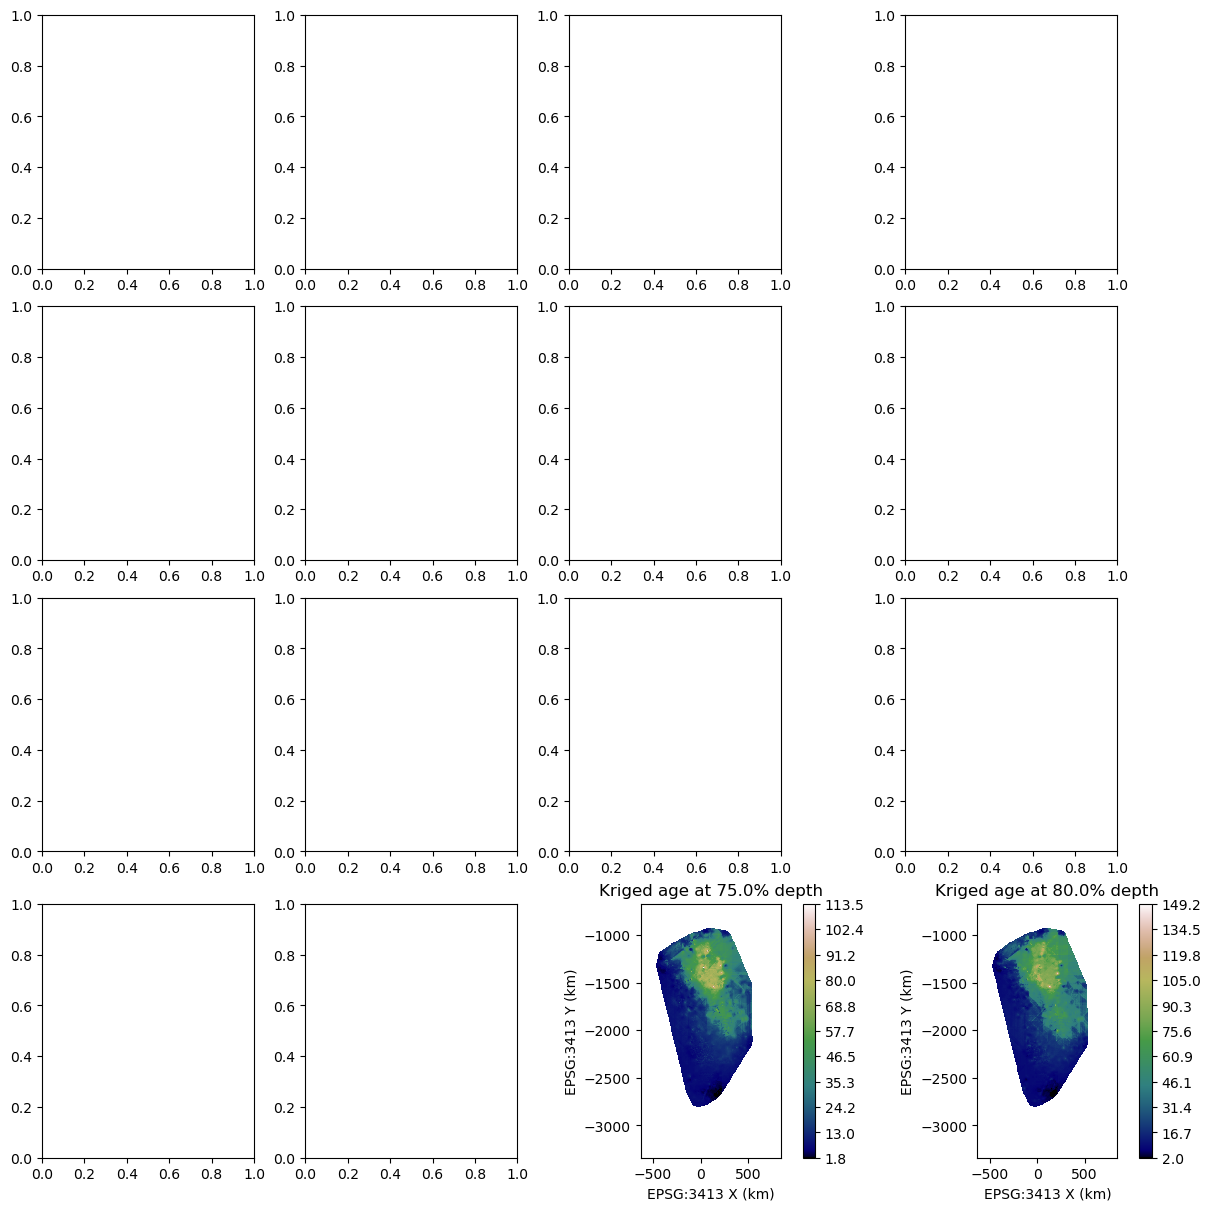

In [8]:
# plot kriged ages
fig, ax = plt.subplots(4, 4, figsize=(12, 12), layout='constrained')
for i in range(num_depth_norm - 4):
    plt.subplot(4, 4, (i + 1))
    im = plt.imshow((1e-3 * age_norm_krige[i]), extent=(1e-3 * np.array([x_min, x_max, y_min, y_max])), 
                   cmap='gist_earth', vmin=(1e-3 * np.nanmin(age_norm_krige[i])), vmax=(1e-3 * np.nanmax(age_norm_krige[i])), interpolation='none', origin='upper')
    plt.title('Kriged age at ' + str(depth_norm[i]) + '% depth')
    plt.xlabel('EPSG:3413 X (km)')
    plt.ylabel('EPSG:3413 Y (km)')
    plt.axis(1e-3 * np.array([x_min, x_max, y_min, y_max]))
    plt.gca().set_aspect('equal')
    plt.colorbar(im, ticks=np.linspace((1e-3 * np.nanmin(age_norm_krige[i])), np.nanmax((1e-3 * age_norm_krige[i])), 11))

In [ ]:
# SAVE ISOCHRONE DEPTH .MAT FILE

depth_iso = np.full((num_yy_grd, num_xx_grd, num_age_iso), np.nan)
depth_iso_std, depth_iso_uncert = np.copy(depth_iso), np.copy(depth_iso)

for i in range(num_age_iso):
    depth_iso[:, :, i] = depth_iso_krige[i]
    depth_iso_std[:, :, i] = depth_iso_std_krige[i]
    depth_iso_uncert[:, :, i] = depth_iso_uncert_krige[i]

vars2save = ['xx_grd', 'yy_grd', 'age_iso', 'depth_iso', 'depth_iso_std', 'depth_iso_uncert']
mat_data = {} # make a dictionary to store the MAT data in
for var_curr in vars2save:
    exec(f'mat_data[u"{var_curr}"] = {var_curr}')

hdf5storage.savemat(path_mat + 'depth_iso_krige.mat', mat_data, format='7.3', oned_as='row', store_python_metadata=True)

In [9]:
# SAVE DEPTH-NORMALIZED AGE .MAT FILE

age_norm = np.full((num_yy_grd, num_xx_grd, (num_depth_norm - 4)), np.nan)
age_norm_std, age_norm_uncert = np.copy(age_norm), np.copy(age_norm)

for i in range(num_depth_norm - 4):
    age_norm[:, :, i] = age_norm_krige[i]
    age_norm_std[:, :, i] = age_norm_std_krige[i]
    age_norm_uncert[:, :, i] = age_norm_uncert_krige[i]

vars2save = ['xx_grd', 'yy_grd', 'depth_norm', 'age_norm', 'age_norm_std', 'age_norm_uncert']
mat_data = {} # make a dictionary to store the MAT data in
for var_curr in vars2save:
    exec(f'mat_data[u"{var_curr}"] = {var_curr}')

hdf5storage.savemat(path_mat + 'age_norm_krige.mat', mat_data, format='7.3', oned_as='row', store_python_metadata=True)